### Exploring the files with Pandas
Many statistical Python packages can deal with numpy Arrays.

Numpy Arrays however are not always easy to use. 

Pandas is a package that provides a dataframe interface, similar to what R uses as the main data structure.
Since Pandas has become so popular, many packages accept both pd.DataFrames and numpy Arrays.

In [1]:
import os
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

### First some environment variables
We now use the files that are stored in the RAW directory.

If we decide to change the data format by changing names, adding features, created summary data frames etc., we will save those files in the INTERIM directory.

In [2]:
PROJECT_DIR = os.path.dirname(dotenv_path)
RAW_DATA_DIR = PROJECT_DIR + os.environ.get("RAW_DATA_DIR")
INTERIM_DATA_DIR = PROJECT_DIR + os.environ.get("INTERIM_DATA_DIR")
files=os.environ.get("FILES").split()

print("Project directory is  : {0}".format(PROJECT_DIR))
print("Raw data directory is : {0}".format(RAW_DATA_DIR))
print("Interim directory is  : {0}".format(INTERIM_DATA_DIR))

Project directory is  : /home/gsentveld/lunch_and_learn
Raw data directory is : /home/gsentveld/lunch_and_learn/data/raw
Interim directory is  : /home/gsentveld/lunch_and_learn/data/interim


### Importing pandas and matplotlib.pyplot

In [3]:
# The following jupyter notebook magic makes the plots appear in the notebook. 
# If you run in batch mode, you have to save your plots as images.
%matplotlib inline

# matplotlib.pyplot is traditionally imported as plt
import matplotlib.pyplot as plt

# numpy is imported as np
import numpy as np

# Pandas is traditionaly imported as pd.
import pandas as pd
from pylab import rcParams

# some display options to size the figures. feel free to experiment
pd.set_option('display.max_columns', 25)
rcParams['figure.figsize'] = (17, 7)

### Reading a file in Pandas
Reading a CSV file is really easy in Pandas. There are several formats that Pandas can deal with.

|Format Type|Data Description|Reader|Writer|
|---|---|---|---|
|text|CSV|read_csv|to_csv|
|text|JSON|read_json|to_json|
|text|HTML|read_html|to_html|
|text|Local clipboard|read_clipboard|to_clipboard|
|binary|MS Excel|read_excel|to_excel|
|binary|HDF5 Format|read_hdf|to_hdf|
|binary|Feather Format|read_feather|to_feather|
|binary|Msgpack|read_msgpack|to_msgpack|
|binary|Stata|read_stata|to_stata|
|binary|SAS|read_sas ||
|binary|Python Pickle Format|read_pickle|to_pickle|
|SQL|SQL|read_sql|to_sql|
|SQL|Google Big Query|read_gbq|to_gbq|

## We now will create a Probabilistic Graphical Model from the data set constructed

Because the dataset is a real world dataset with data about many different aspects of the sample population, the data is not as nice for a regression or classification like the Iris dataset or the MPG data set.

What does work very well for such a data set is the use of a Probabilistic Graphical Model.

A good article describing PGM and a commonly used library pgmpy

- http://conference.scipy.org/proceedings/scipy2015/pdfs/ankur_ankan.pdf

- http://pgmpy.org/



In [4]:
df=pd.read_csv(INTERIM_DATA_DIR+'/arthritis_study.csv', index_col=0)

### Preparing the data
We will prepare the data by filtering some of the columns. This is for practical reasons for the lunch and learn. In reality you would leave all data in and only drop columns after determining they are not relevant for the model.

We also will split the data in a Train and Test dataset. This allows us to check how good the model predicts. The cool part is, with PGM, you can predict any of the columns.

In [5]:
from sklearn.cross_validation import train_test_split

columns_of_interest=['ARTH1','SPD','AGE_C', 'CHRONIC_CT','FUNC_LIMIT','SOC_RESTR','POV_RATIO','ACTIVITY']

data, test, y, test_y = train_test_split(df[columns_of_interest], df['ARTH1'], test_size=0.1, random_state=42, stratify=[ 0 if x=="Yes" else 1 for x in df['ARTH1']])
print("Number of samples in data: {}".format(data.shape[0]))
print("Number of samples in test: {}".format(test.shape[0]))

Number of samples in data: 30304
Number of samples in test: 3368


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We need to drop any rows that still have NaN values

In [6]:
# to avoid problems later on we remove any rows that have any 
data.dropna(axis=0, how='any', inplace=True)
test.dropna(axis=0, how='any', inplace=True)
print("Number of samples in data: {}".format(data.shape[0]))
print("Number of samples in test: {}".format(test.shape[0]))


Number of samples in data: 30264
Number of samples in test: 3362


### Probabilistic Graphical Models


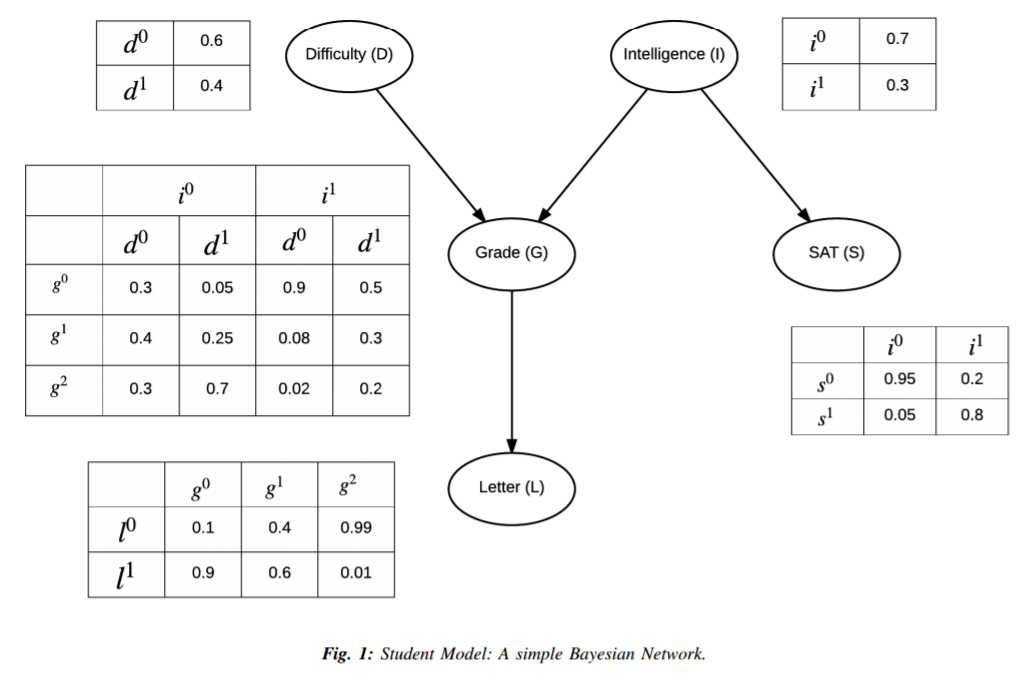

In [7]:
from IPython.display import Image
Image(filename='Student_Bayesian_Network_Example.PNG') 

### Learning a Bayesian Network from data

If you don't yet have a network, you can learn it from the data itself.

There are 2 ways to do so, and I will demonstrate the Constraint Base way.

We start by creating a ConstraintBasedEstimator object and pass it the data.

In [8]:
import pgmpy

from pgmpy.estimators import ConstraintBasedEstimator
est = ConstraintBasedEstimator(data)

First we stry to create a skeleton that is one of the many possible networks between the nodes. It does that by doing various statistical tests, like the Student test, Chi squared test, etc. (depending on the library you use and the type of data you have or the type of distribution you told the variables to be), between the different values of sets of features. If there is a significant difference, you can argue that one features influences the values of the other.

In [9]:
# don't think we will go over this. 
def is_independent(X, Y, Zs=[], significance_level=0.05):
    return est.test_conditional_independence(X, Y, Zs)[1] >= significance_level


In [10]:
for i in data.columns:
    for j in data.columns:
        print("relation between {} and {} is independent?: {}".format(i,j, is_independent('FUNC_LIMIT','POV_RATIO')))

relation between ARTH1 and ARTH1 is independent?: False
relation between ARTH1 and SPD is independent?: False
relation between ARTH1 and AGE_C is independent?: False
relation between ARTH1 and CHRONIC_CT is independent?: False
relation between ARTH1 and FUNC_LIMIT is independent?: False
relation between ARTH1 and SOC_RESTR is independent?: False
relation between ARTH1 and POV_RATIO is independent?: False
relation between ARTH1 and ACTIVITY is independent?: False
relation between SPD and ARTH1 is independent?: False
relation between SPD and SPD is independent?: False
relation between SPD and AGE_C is independent?: False
relation between SPD and CHRONIC_CT is independent?: False
relation between SPD and FUNC_LIMIT is independent?: False
relation between SPD and SOC_RESTR is independent?: False
relation between SPD and POV_RATIO is independent?: False
relation between SPD and ACTIVITY is independent?: False
relation between AGE_C and ARTH1 is independent?: False
relation between AGE_C and

In [11]:
# this step takes a long time with a dataset as big as we have
# without a model, the estimator will pairwise check independece for all categorical values for all combinations of columns
skel, seperating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

Undirected edges:  [('ARTH1', 'AGE_C'), ('ARTH1', 'CHRONIC_CT'), ('ARTH1', 'FUNC_LIMIT'), ('ARTH1', 'SOC_RESTR'), ('SPD', 'SOC_RESTR'), ('SPD', 'POV_RATIO'), ('AGE_C', 'CHRONIC_CT'), ('AGE_C', 'FUNC_LIMIT'), ('AGE_C', 'POV_RATIO'), ('CHRONIC_CT', 'FUNC_LIMIT'), ('CHRONIC_CT', 'SOC_RESTR'), ('FUNC_LIMIT', 'SOC_RESTR'), ('FUNC_LIMIT', 'POV_RATIO'), ('POV_RATIO', 'ACTIVITY')]


Now that we have a skeleton there are some bidirectional and some loops still in the mix.

We need to recalculate the probabilities of the different options to check which one has the overall best cohesion. 

In [12]:
# With an estimate of the skeleton, we can now add probabilities to the edges
pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

PDAG edges:        [('ARTH1', 'AGE_C'), ('ARTH1', 'CHRONIC_CT'), ('ARTH1', 'FUNC_LIMIT'), ('ARTH1', 'SOC_RESTR'), ('AGE_C', 'ARTH1'), ('AGE_C', 'FUNC_LIMIT'), ('CHRONIC_CT', 'ARTH1'), ('CHRONIC_CT', 'AGE_C'), ('CHRONIC_CT', 'FUNC_LIMIT'), ('CHRONIC_CT', 'SOC_RESTR'), ('FUNC_LIMIT', 'ARTH1'), ('FUNC_LIMIT', 'AGE_C'), ('FUNC_LIMIT', 'CHRONIC_CT'), ('FUNC_LIMIT', 'SOC_RESTR'), ('FUNC_LIMIT', 'POV_RATIO'), ('SOC_RESTR', 'ARTH1'), ('SOC_RESTR', 'SPD'), ('SOC_RESTR', 'CHRONIC_CT'), ('SOC_RESTR', 'FUNC_LIMIT'), ('POV_RATIO', 'AGE_C'), ('POV_RATIO', 'FUNC_LIMIT'), ('ACTIVITY', 'POV_RATIO')]


Now that we have the Probabilities calculated, we can eliminate the bi-directional ones and turn the network into a proper DAG.

In [13]:
# and finally based on the probabilities of the directionality, make a decision
model = est.pdag_to_dag(pdag)

print("DAG edges:        ", model.edges())

DAG edges:         [('ARTH1', 'SOC_RESTR'), ('ARTH1', 'AGE_C'), ('ARTH1', 'CHRONIC_CT'), ('ARTH1', 'FUNC_LIMIT'), ('AGE_C', 'FUNC_LIMIT'), ('CHRONIC_CT', 'AGE_C'), ('CHRONIC_CT', 'SOC_RESTR'), ('CHRONIC_CT', 'FUNC_LIMIT'), ('FUNC_LIMIT', 'SOC_RESTR'), ('SOC_RESTR', 'SPD'), ('POV_RATIO', 'AGE_C'), ('POV_RATIO', 'FUNC_LIMIT'), ('ACTIVITY', 'POV_RATIO')]


/opt/conda/lib/python3.6/site-packages/pgmpy-0.1.3-py3.6.egg/pgmpy/estimators/ConstraintBasedEstimator.py:326: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  "oriented arbitrarily.")


### Visualize the graph

It is not easy to visualize the DAG based on the list of tuples.

So we use some based networkx plotting capabilities. Not the greatest, but networkx is the underlying library used by pgmpy to represent the data, so it is the easiest.

You can let networkx determine the layout of the data, but with this data, we want to be more in control. So we define the positions 

In [14]:
pos={'ACTIVITY': [ 2,3],
 'AGE_C': [ 1,5],
 'ARTH1': [ 3,5],
 'CHRONIC_CT': [4,7],
 'FUNC_LIMIT': [ 4,3],
 'POV_RATIO': [ 6,3],
 'SOC_RESTR': [ 5,5],
 'SPD': [ 7,5]}

{'ACTIVITY': <matplotlib.text.Text at 0x7f24a8f97518>,
 'AGE_C': <matplotlib.text.Text at 0x7f24a8fe1668>,
 'ARTH1': <matplotlib.text.Text at 0x7f24a8fd8c50>,
 'CHRONIC_CT': <matplotlib.text.Text at 0x7f24a8fe1ba8>,
 'FUNC_LIMIT': <matplotlib.text.Text at 0x7f24a8ff3128>,
 'POV_RATIO': <matplotlib.text.Text at 0x7f24a8ff3ba8>,
 'SOC_RESTR': <matplotlib.text.Text at 0x7f24a8ff3668>,
 'SPD': <matplotlib.text.Text at 0x7f24a8fe1128>}

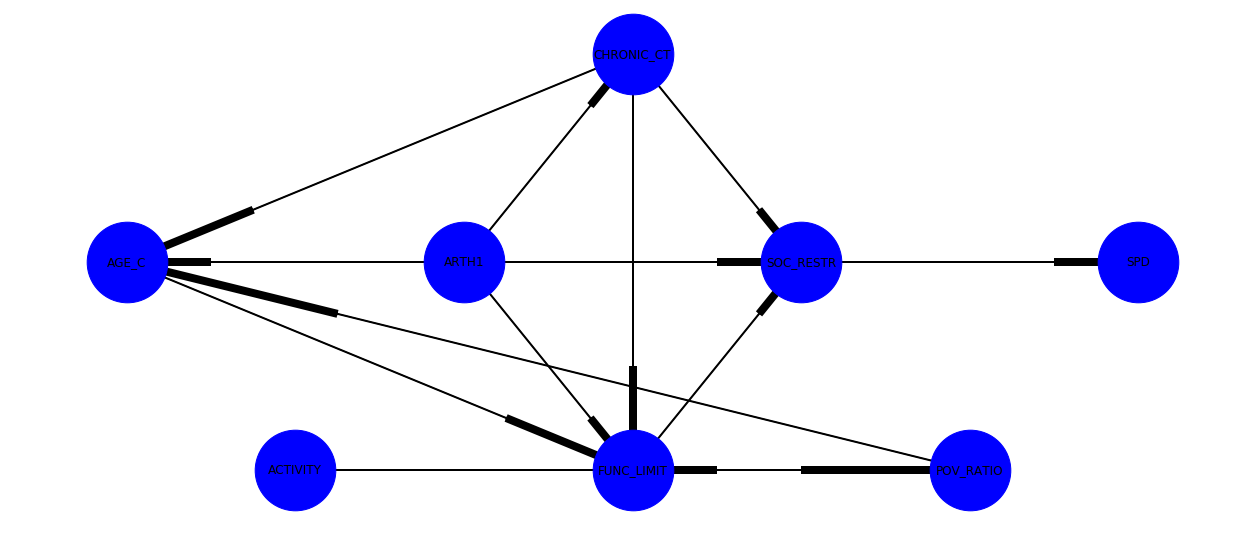

In [15]:
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
nx.draw(model,pos=pos,node_size=6500, width=2, node_color='b')
nx.draw_networkx_edges(model,pos=pos)
nx.draw_networkx_labels(model,pos=pos)

In [16]:
# adding the states to the model

for col in data.columns:
    print(col)
    print(data[col].unique())
    model.node[col] = { 'STATES': data[col].unique() }

#for var, properties in nodes.items():
#    model.node[var] = properties

ARTH1
['No' 'Yes']
SPD
['No' 'Yes']
AGE_C
['65-' '18-44' '45-64']
CHRONIC_CT
['1' '2' '0' '>=3']
FUNC_LIMIT
['High' 'None' 'Medium' 'Low']
SOC_RESTR
['Yes' 'No']
POV_RATIO
['>=2' '1 to <2' '<1']
ACTIVITY
['Does not meet' 'Meets']


###  Conditional Probability Distributions (CPD)
Now that we have created the network, we can 'refit' the data and calculate the Conditional Probability Distributions.


In [17]:
# we could add any additional info to the model at this point, that adjusts our prior.

# now update the CPD's given the data.
model.fit(data)

for cpd in model.get_cpds():
    if cpd.variable in ('ARTH1','CHRONIC_CT'):
        print(cpd.variable)
        print(cpd)

ARTH1
╒════════════╤══════════╕
│ ARTH1(No)  │ 0.741607 │
├────────────┼──────────┤
│ ARTH1(Yes) │ 0.258393 │
╘════════════╧══════════╛
CHRONIC_CT
╒═════════════════╤═════════════════════╤═════════════════════╕
│ ARTH1           │ ARTH1(No)           │ ARTH1(Yes)          │
├─────────────────┼─────────────────────┼─────────────────────┤
│ CHRONIC_CT(0)   │ 0.611299233648191   │ 0.24936061381074168 │
├─────────────────┼─────────────────────┼─────────────────────┤
│ CHRONIC_CT(1)   │ 0.2618071644983069  │ 0.3276214833759591  │
├─────────────────┼─────────────────────┼─────────────────────┤
│ CHRONIC_CT(2)   │ 0.08679379789698806 │ 0.23861892583120203 │
├─────────────────┼─────────────────────┼─────────────────────┤
│ CHRONIC_CT(>=3) │ 0.04009980395651399 │ 0.18439897698209717 │
╘═════════════════╧═════════════════════╧═════════════════════╛


### Testing the accuracy of the model

At the beginning we set some data aside that was not used to create the model. Now we can use that to test our model's accuracy.

In [18]:
# OK, so now that we fit the data against the training set, we can test against the test set.
# we first create a version that does not have the value we want to test the accuracy of the model for.
test_x = test.copy()

# get the actual values for SPD for the dataset
test_y = test_x['ARTH1']

# then remove it from the data
test_x.drop('ARTH1', axis=1, inplace=True)

# now let the model predict the values
y_pred=model.predict(test_x)


from sklearn.metrics import f1_score, accuracy_score
y_true=[ 'No' if x is None else x for x in test_y ]

print(f1_score(y_true, y_pred, average='micro'))


0.786139202855


That was not that great. But we know from the paper that the data is not predicting Arthritis, but the likelihood of having SPD with or without Arthritis. So how good is the model at predicting SPD.

In [19]:
# Is the Model better at predicting SPD?

# have to remove rows where SPD is blank
test_x = test.copy()

# get the actual values for SPD for the dataset
test_y = test_x['SPD']
# then remove it from the data
test_x.drop('SPD', axis=1, inplace=True)

# have the model predict the value
y_pred=model.predict(test_x)

In [20]:
from sklearn.metrics import f1_score, accuracy_score
y_true=[ 'No' if x is None else x for x in test_y ]


print(f1_score(y_true, y_pred, average='micro'))

0.970850684117


### Predicting based on partial evidence.
Now we can predict full sets of data and infer missing columns in bulk, and we saw that the F1 score was not that great for predicting ARTH1.

However, on a case by case basis, this model can be very valuable if you look at the predicted probabilities for incomplete situation, especially if you are slowly gathering evidence.

Here an example of the likelihood of Arthritis by itself, and with more evidence.

In [21]:
# Set up for inference of 
from pgmpy.inference import   VariableElimination
infer = VariableElimination(model)

print(infer.query(['ARTH1'])['ARTH1'] )
print(infer.query(['ARTH1'], evidence={'CHRONIC_CT': 2})['ARTH1'] )
print(infer.query(['ARTH1'], evidence={'CHRONIC_CT': 2, 'AGE_C':2, 'FUNC_LIMIT':2})['ARTH1'] )

╒═════════╤══════════════╕
│ ARTH1   │   phi(ARTH1) │
╞═════════╪══════════════╡
│ ARTH1_0 │       0.7416 │
├─────────┼──────────────┤
│ ARTH1_1 │       0.2584 │
╘═════════╧══════════════╛
╒═════════╤══════════════╕
│ ARTH1   │   phi(ARTH1) │
╞═════════╪══════════════╡
│ ARTH1_0 │       0.5107 │
├─────────┼──────────────┤
│ ARTH1_1 │       0.4893 │
╘═════════╧══════════════╛
╒═════════╤══════════════╕
│ ARTH1   │   phi(ARTH1) │
╞═════════╪══════════════╡
│ ARTH1_0 │       0.2948 │
├─────────┼──────────────┤
│ ARTH1_1 │       0.7052 │
╘═════════╧══════════════╛


Also interesting is the rise in probability of SPD given some evidence, compared to just by itself.

In [22]:
print(infer.query(['SPD'])['SPD'] )
print(infer.query(['SPD'], evidence={'CHRONIC_CT': 2, 'POV_RATIO':1, 'SOC_RESTR':1, 'FUNC_LIMIT':1})['SPD'] )

╒═══════╤════════════╕
│ SPD   │   phi(SPD) │
╞═══════╪════════════╡
│ SPD_0 │     0.9630 │
├───────┼────────────┤
│ SPD_1 │     0.0370 │
╘═══════╧════════════╛
╒═══════╤════════════╕
│ SPD   │   phi(SPD) │
╞═══════╪════════════╡
│ SPD_0 │     0.8575 │
├───────┼────────────┤
│ SPD_1 │     0.1425 │
╘═══════╧════════════╛


### Now with a given model.
When you have some idea of what the causal relations are, you can provide that instead of learn it from the data.

So what if I would put my very uneducated guess on what influences arthritis and what influences SPD out of this set of 8 features. I would come up with something like this.

And, besides the scope for today, but if I knew the CPD between to variables, I could provide those as well. Either as prior, before fitting the data, or, just override the one that is created from fitting the data. You need to have confidence in the prior to do the former, and extreme confidence in the prior, or know your data sample is biased against your prior, to do the latter.

In [23]:
from pgmpy.models import BayesianModel

edges=[('AGE_C','ARTH1'), ('AGE_C','CHRONIC_CT'),('AGE_C','FUNC_LIMIT')
      ,('ACTIVITY','ARTH1') 
      ,('ARTH1','FUNC_LIMIT'),('ARTH1','SOC_RESTR')
      ,('CHRONIC_CT','FUNC_LIMIT'),('CHRONIC_CT','SOC_RESTR'),('CHRONIC_CT','SPD')
      ,('SOC_RESTR','SPD')
      ,('FUNC_LIMIT','SPD')
      ,('POV_RATIO','SPD')
      ]

altmodel = BayesianModel()

altmodel.add_edges_from(edges)

{'ACTIVITY': <matplotlib.text.Text at 0x7f24a8eb7cc0>,
 'AGE_C': <matplotlib.text.Text at 0x7f24b37c0668>,
 'ARTH1': <matplotlib.text.Text at 0x7f24a8ebaf60>,
 'CHRONIC_CT': <matplotlib.text.Text at 0x7f24a8eb7240>,
 'FUNC_LIMIT': <matplotlib.text.Text at 0x7f24a8eb7780>,
 'POV_RATIO': <matplotlib.text.Text at 0x7f24a8ec6cc0>,
 'SOC_RESTR': <matplotlib.text.Text at 0x7f24a8ec6240>,
 'SPD': <matplotlib.text.Text at 0x7f24a8ec6780>}

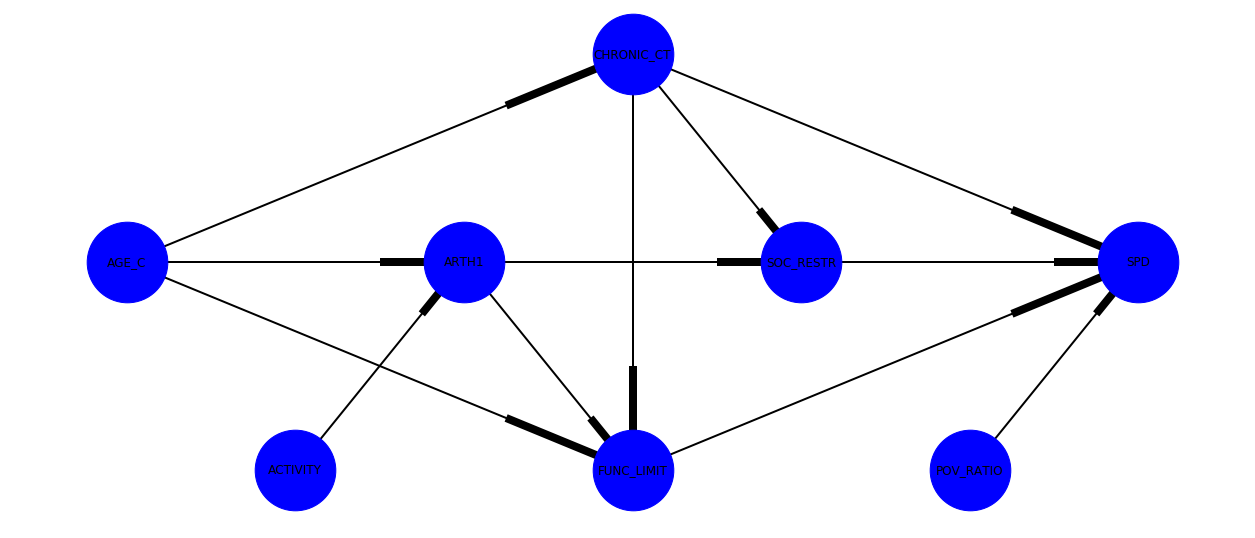

In [24]:
import warnings
warnings.filterwarnings("ignore")
nx.draw(altmodel,pos=pos,node_size=6500, width=2, node_color='b')
nx.draw_networkx_labels(altmodel,pos=pos)

### Fit the data

In [25]:
altmodel.fit(data)

for cpd in altmodel.get_cpds():
    if cpd.variable in ('ARTH1','CHRONIC_CT'):
        print(cpd.variable)
        print(cpd)

ARTH1
╒════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤══════════════════════╤════════════════════╤════════════════════╕
│ ACTIVITY   │ ACTIVITY(Does not meet) │ ACTIVITY(Does not meet) │ ACTIVITY(Does not meet) │ ACTIVITY(Meets)      │ ACTIVITY(Meets)    │ ACTIVITY(Meets)    │
├────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼──────────────────────┼────────────────────┼────────────────────┤
│ AGE_C      │ AGE_C(18-44)            │ AGE_C(45-64)            │ AGE_C(65-)              │ AGE_C(18-44)         │ AGE_C(45-64)       │ AGE_C(65-)         │
├────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼──────────────────────┼────────────────────┼────────────────────┤
│ ARTH1(No)  │ 0.9180041152263374      │ 0.6853618803816616      │ 0.4845683614134486      │ 0.9380469023451172   │ 0.7768595041322314 │ 0.5891758917589176 │
├────────────┼─────────────────────────┼──────

### Predict one more time

In [26]:
y_pred=altmodel.predict(test_x)


from sklearn.metrics import f1_score, accuracy_score
y_true=[ 'No' if x is None else x for x in test_y ]

print(f1_score(y_true, y_pred, average='weighted'))

0.956491588577


So the accuracy went down slightly, but with SPD being unbalanced, and a more realistic network, that is not a bad thing. It will reduce overfitting.

In [27]:
infer = VariableElimination(altmodel)

print(infer.query(['SPD'])['SPD'] )
print(infer.query(['SPD'], evidence={'ARTH1':1,'CHRONIC_CT': 2, 'POV_RATIO':1, 'SOC_RESTR':1, 'FUNC_LIMIT':1})['SPD'] )

╒═══════╤════════════╕
│ SPD   │   phi(SPD) │
╞═══════╪════════════╡
│ SPD_0 │     0.9612 │
├───────┼────────────┤
│ SPD_1 │     0.0388 │
╘═══════╧════════════╛
╒═══════╤════════════╕
│ SPD   │   phi(SPD) │
╞═══════╪════════════╡
│ SPD_0 │     0.7273 │
├───────┼────────────┤
│ SPD_1 │     0.2727 │
╘═══════╧════════════╛


### Verify the results from the paper
Finally, before we end, we will recreate the results of the paper. 

What is the probability of SPD with and without Arhtritis

In [28]:
infer = VariableElimination(altmodel)

print(infer.query(['SPD'], evidence={'ARTH1':0})['SPD'])
print(infer.query(['SPD'], evidence={'ARTH1':1})['SPD'])

╒═══════╤════════════╕
│ SPD   │   phi(SPD) │
╞═══════╪════════════╡
│ SPD_0 │     0.9701 │
├───────┼────────────┤
│ SPD_1 │     0.0299 │
╘═══════╧════════════╛
╒═══════╤════════════╕
│ SPD   │   phi(SPD) │
╞═══════╪════════════╡
│ SPD_0 │     0.9352 │
├───────┼────────────┤
│ SPD_1 │     0.0648 │
╘═══════╧════════════╛


As the paper suggests, the probability increases from around 3% to over 6%.

[Back to Agenda](http://localhost:8000/notebooks/Lunch_And_Learn_Session_3_Index.slides.html)